In [1]:
# these are for importing data
import pystac
import fsspec
import xarray as xr

# keep attributes throughout opeartions
xr.set_options(keep_attrs=True)

# this is for parallel computing
from dask_gateway import GatewayCluster

# these are for geospatial data
import cartopy.crs as ccrs
import geopandas as gpd
import rasterio as rio

# these are for dealing with arrays
import numpy as np
import matplotlib.pyplot as plt

import os

## CLIMATE AVERAGE AND REGIONS FUNCTIONS

In [2]:
# extract crs from ds
def extract_crs(ds):
    lcc = ds.variables["lambert_conformal_conic"].attrs

    prj_kwargs = dict(
        central_latitude=lcc["latitude_of_projection_origin"],
        central_longitude=lcc["longitude_of_central_meridian"],
        standard_parallels=(lcc["standard_parallel"]),
    )
    # https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
    return ccrs.LambertConformal(**prj_kwargs)

In [3]:
# calculate the average tmax or tmin temperature over the time period [year-n+1,year]
# tmax_timin = string 'tmax' or 'tmin' depending on whether you want to compute min or max avg temperature
# year, n = integers
# for best practices according to the World Meteorological Organization, n=30 (see notes on Case Study Diary)

def ca_tmaxmin_avg(tmax_tmin,ds,year,shape,n=30):
    if (year-n+1<1981 or 2019<year):
        print('time range outside the dataset extent')
        return 

    # select time period and write crs
    crs = extract_crs(ds)
    years = ds.sel(time=slice(str(year-n+1),str(year)))[tmax_tmin]
    years = years.rio.write_crs(crs)
    
    # clip over shape and calcualte avg
    ca_avg = years.rio.clip(shape.geometry, shape.crs)
    ca_avg = ca_avg.mean(dim="time")
    
    # update attributes
    [ca_avg.attrs.pop(key) for key in ['cell_methods','grid_mapping']]
    if tmax_tmin == 'tmax':
        ca_avg.attrs['long_name'] = 'average of daily maximum temperature over years ['+str(year-n+1)+','+str(year)+']'
    else:
        ca_avg.attrs['long_name'] =  'average of daily minimum temperature over years ['+str(year-n+1)+','+str(year)+']'
    ca_avg.attrs['year']=year
    ca_avg.attrs['time_period (years)']=n

    # update all CRS info
    ca_avg = ca_avg.reset_coords('lambert_conformal_conic',drop=True)
    ca_avg.rio.write_crs(crs, inplace=True)    
    #ca_avg.attrs['crs']=crs # *** FIX: this data type cannot be an attribute when written***
    ca_avg.rio.set_crs(crs)
         
    return ca_avg 

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------

# calculate the average temperature over the time period [year-n+1,year]
# for best practices according to the World Meteorological Organization, n=30 (see notes on Case Study Diary)
def ca_avg_temp(ds,year,shape,n=30):

    if (year-n+1<1981 or 2019<year):
        print('time range outside the dataset extent')
        return 
    
    ca_min = ca_tmaxmin_avg('tmin',ds,year,shape,n)
    ca_max = ca_tmaxmin_avg('tmax',ds,year,shape,n)
    # remove weird values?
    #ca_max = ca_max.where(ca_max>0)
    avg = (ca_max + ca_min)/2
    avg.attrs['long_name'] =  'average temperature over years ['+str(year-n+1)+','+str(year)+']'
    
    return avg

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
#clim = xarray.DataArray of average temperature

def clim_regions(clim):
    # extract numpy.ndarray
    trgns = clim.to_numpy()
    # establish thresholds
    k = [0,10,18,24]
    # group into regions
    trgns[np.where( (k[0]<=trgns) & (trgns<k[1]))] = 3
    trgns[np.where( trgns< k[0])] = 2
    trgns[np.where( (k[1]<=trgns) & (trgns<k[2]))] = 4
    trgns[np.where( (k[2]<=trgns) & (trgns<k[3]))] = 5
    trgns[np.where(k[3]<=trgns)] = 6
    
    # create xarray.DataArray with np.ndarray
    t_regions = xr.DataArray(
        data= trgns,
        dims= clim.dims,
        coords= clim.coords,
        attrs= clim.attrs
        )
    
    # update attributes
    t_regions.attrs.pop('units')
    t_regions.attrs['long_name'] = 'climate regions, year ' + str(clim.attrs['year'])
    # include a dictionary of temp regions
    t_regions.attrs['code_2'] = 'polar or boreal: temp less than '+str(k[0])
    t_regions.attrs['code_3'] = 'cold temperate: temp in ['+str(k[0])+','+str(k[1])+')'
    t_regions.attrs['code_4'] = 'warm temperate: temp in ['+str(k[1])+','+str(k[2])+')'
    t_regions.attrs['code_5'] = 'subtropical: temp in ['+str(k[2])+','+str(k[3])+')'
    t_regions.attrs['code_6'] = 'tropical: temp geq than '+str(k[3])
    # d = { 2: 'polar or boreal: temp less than '+str(k[0]) ,
    #     3: 'cold temperate: temp in ['+str(k[0])+','+str(k[1])+')',
    #     4: 'warm temperate: temp in ['+str(k[1])+','+str(k[2])+')',
    #     5: 'subtropical: temp in ['+str(k[2])+','+str(k[3])+')',
    #     6: 'tropical: temp geq than '+str(k[3]) } 
    # t_regions.attrs['regions_codes'] = d
    
    return t_regions

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------
# recent, past = xarray.DataArrays of climate regions
def clim_rgns_increase(recent, past):
    increase = recent-past
    increase = increase.where(increase>0)
    
    [increase.attrs.pop(key) for key in ['year','time_period (years)']]
    for i in range(2,7):
        increase.attrs.pop('code_'+str(i))
    increase.attrs['long_name'] = 'increase in climate regions from '+str(past.attrs['year'])+' to '+str(recent.attrs['year'])
    increase.attrs['years_compared'] = (past.attrs['year'],recent.attrs['year'])
    return increase

## DATA LOADING

In [4]:
# accessing collection 
url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-annual-na"
collection = pystac.read_file(url)

asset = collection.assets["zarr-https"]

# open as xarray dataset
store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
crs = extract_crs(ds)
ds

<xarray.Dataset>
Dimensions:                  (y: 8075, x: 7814, time: 41, nv: 2)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-07-01T12:00:00 ... 20...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980

In [5]:
# import CA shapefile
ca_shape_path = "/home/jovyan/Sedgwick_Reserve/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)

# match CRS
ca_lambert = ca_shape.to_crs(crs)

## EXAMPLES

In [6]:
init_yr = 2008
end_yr = 2019
#n=30 # 30 for best practices
n=25

### max and min avg temp

<xarray.DataArray 'tmax' (y: 1149, x: 706)>
dask.array<mean_agg-aggregate, shape=(1149, 706), dtype=float32, chunksize=(1149, 706), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2.24e+05 2.23e+05 2.22e+05 ... -9.23e+05 -9.24e+05
  * x            (x) float64 -1.955e+06 -1.954e+06 ... -1.251e+06 -1.25e+06
    lat          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    spatial_ref  int64 0
Attributes:
    long_name:            average of daily maximum temperature over years [19...
    units:                degrees C
    year:                 2019
    time_period (years):  30

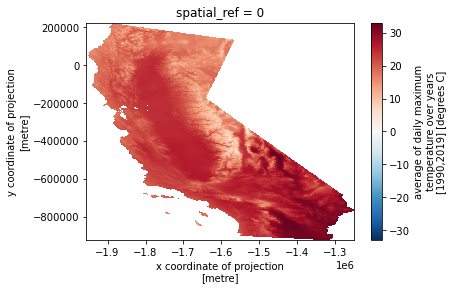

In [7]:
ca_max = ca_tmaxmin_avg('tmax',ds,end_yr,ca_lambert)
ca_max.plot()
ca_max

<xarray.DataArray 'tmin' (y: 1149, x: 706)>
dask.array<mean_agg-aggregate, shape=(1149, 706), dtype=float32, chunksize=(1149, 706), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2.24e+05 2.23e+05 2.22e+05 ... -9.23e+05 -9.24e+05
  * x            (x) float64 -1.955e+06 -1.954e+06 ... -1.251e+06 -1.25e+06
    lat          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    spatial_ref  int64 0
Attributes:
    long_name:            average of daily minimum temperature over years [19...
    units:                degrees C
    year:                 2019
    time_period (years):  30

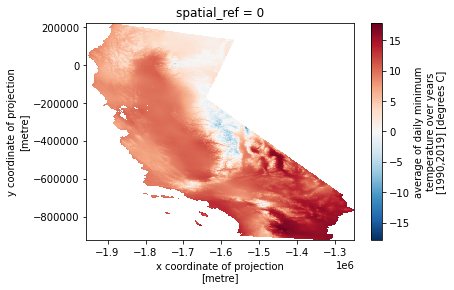

In [8]:
ca_min = ca_tmaxmin_avg('tmin',ds,end_yr,ca_lambert)
ca_min.plot()
ca_min

### avg temp over time period

In [9]:
ca_avg_end = ca_avg_temp(ds,end_yr,ca_lambert,n)
ca_avg_end
ca_avg_end.plot()
#ca_avg_end.attrs

<xarray.DataArray (y: 1149, x: 706)>
dask.array<truediv, shape=(1149, 706), dtype=float32, chunksize=(1149, 706), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2.24e+05 2.23e+05 2.22e+05 ... -9.23e+05 -9.24e+05
  * x            (x) float64 -1.955e+06 -1.954e+06 ... -1.251e+06 -1.25e+06
    lat          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    spatial_ref  int64 0
Attributes:
    long_name:            average temperature over years [1995,2019]
    units:                degrees C
    year:                 2019
    time_period (years):  25

In [10]:
ca_avg_init = ca_avg_temp(ds,init_yr,ca_lambert,n)
ca_avg_init

<xarray.DataArray (y: 1149, x: 706)>
dask.array<truediv, shape=(1149, 706), dtype=float32, chunksize=(1149, 706), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2.24e+05 2.23e+05 2.22e+05 ... -9.23e+05 -9.24e+05
  * x            (x) float64 -1.955e+06 -1.954e+06 ... -1.251e+06 -1.25e+06
    lat          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    spatial_ref  int64 0
Attributes:
    long_name:            average temperature over years [1984,2008]
    units:                degrees C
    year:                 2008
    time_period (years):  25

### climate regions

In [11]:
ca_rgns_end = clim_regions(ca_avg_end)
#ca_rgns_end.plot()
ca_rgns_end

<xarray.DataArray (y: 1149, x: 706)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 2.24e+05 2.23e+05 2.22e+05 ... -9.23e+05 -9.24e+05
  * x            (x) float64 -1.955e+06 -1.954e+06 ... -1.251e+06 -1.25e+06
    lat          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    spatial_ref  int64 0
Attributes:
    long_name:            climate regions, year 2019
    year:                 2019
    time_period (years):  25
    code_2:               polar or boreal: temp less than 0
    code_3:               cold temperate: temp in [0,10)
    code_4:               warm temperate: temp in [10,18)
    code_5:               subtropical: temp in [18,24)
    code_6:               tropical: temp geq than 24

{'long_name': 'climate regions, year 2008',
 'year': 2008,
 'time_period (years)': 25,
 'code_2': 'polar or boreal: temp less than 0',
 'code_3': 'cold temperate: temp in [0,10)',
 'code_4': 'warm temperate: temp in [10,18)',
 'code_5': 'subtropical: temp in [18,24)',
 'code_6': 'tropical: temp geq than 24'}

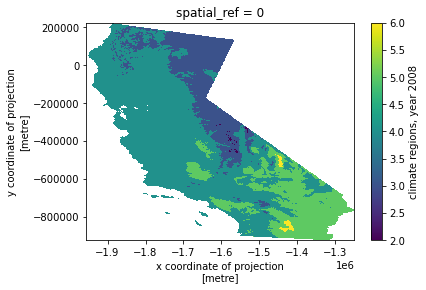

In [12]:
ca_rgns_init = clim_regions(ca_avg_init)
ca_rgns_init.plot()
ca_rgns_init.attrs

### temp increase raster

In [13]:
inc = clim_rgns_increase(ca_rgns_end,ca_rgns_init)
#inc.plot()
inc

<xarray.DataArray (y: 1149, x: 706)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * y            (y) float64 2.24e+05 2.23e+05 2.22e+05 ... -9.23e+05 -9.24e+05
  * x            (x) float64 -1.955e+06 -1.954e+06 ... -1.251e+06 -1.25e+06
    lat          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(1149, 706), meta=np.ndarray>
    spatial_ref  int64 0
Attributes:
    long_name:       increase in climate regions from 2008 to 2019
    years_compared:  (2008, 2019)

In [14]:
print(crs.to_epsg())

None


## SAVING FILE

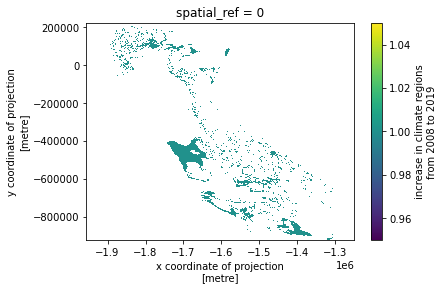

In [15]:
#https://xarray.pydata.org/en/stable/user-guide/io.html
file_name = "clim_increase_"+str(init_yr)+"_"+str(end_yr)+".nc"
outfp = "/home/jovyan/climate_layer/" + file_name
inc.to_netcdf(outfp)

check = xr.open_dataarray(outfp)
check.plot()

In [16]:
check

<xarray.DataArray (y: 1149, x: 706)>
[811194 values with dtype=float32]
Coordinates:
  * y            (y) float32 2.24e+05 2.23e+05 2.22e+05 ... -9.23e+05 -9.24e+05
  * x            (x) float32 -1.955e+06 -1.954e+06 ... -1.251e+06 -1.25e+06
    lat          (y, x) float32 ...
    lon          (y, x) float32 ...
    spatial_ref  int64 ...
Attributes:
    long_name:       increase in climate regions from 2008 to 2019
    years_compared:  [2008 2019]